# Jonathan Halverson
# Tuesday, December 5, 2017
# Speech recognition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from scipy.io import wavfile

f = 'datasets/speech_commands_v0.01/yes/0a7c2a8d_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/eight/3a70ab7f_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/marvin/4a4e28f1_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/marvin/5a9f7324_nohash_0.wav' # low freq
f = 'datasets/speech_commands_v0.01/marvin/6a861f21_nohash_0.wav' # high freq
sample_rate, data = wavfile.read(f)
times = np.arange(data.size) / float(sample_rate)

How many samples per second are there?

In [3]:
sample_rate

16000

What do the first ten values look like?

In [4]:
data[:10]

array([ 1,  3,  3,  1,  0,  0,  0,  0,  0, -1], dtype=int16)

How many samples are there?

In [5]:
data.size

16000

How many unique values are there?

In [6]:
np.unique(data).size

7259

What are the min, mean and max values?

In [7]:
data.min(), data.mean(), data.max()

(-28099, -0.20075000000000001, 32767)

Here is the waveform of someone saying the word 'yes':

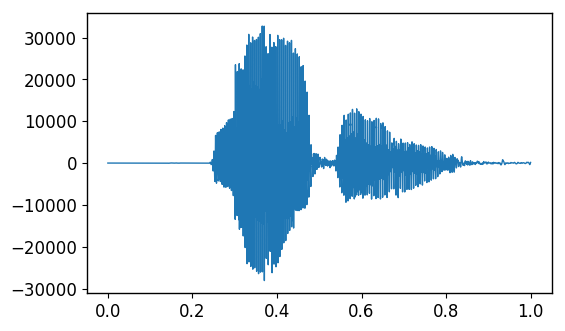

In [8]:
plt.plot(times, data)

(0.25, 0.8)

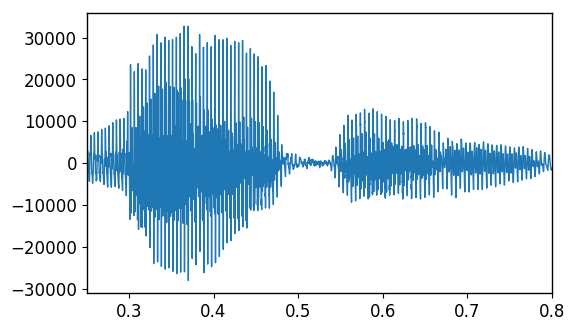

In [9]:
plt.plot(times, data)
plt.xlim(0.25, 0.8)

Here is 1/100 of second in the middle:

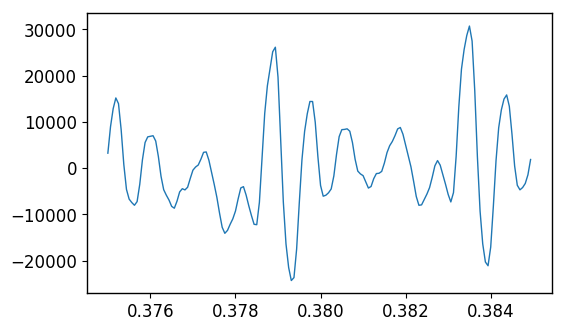

In [10]:
plt.plot(np.arange(6000, 6160) / float(sample_rate), data[6000:6160])

### Let's make a spectrogram manually

The idea is to compute the DFT within a set of windows:

In [11]:
from numpy import fft

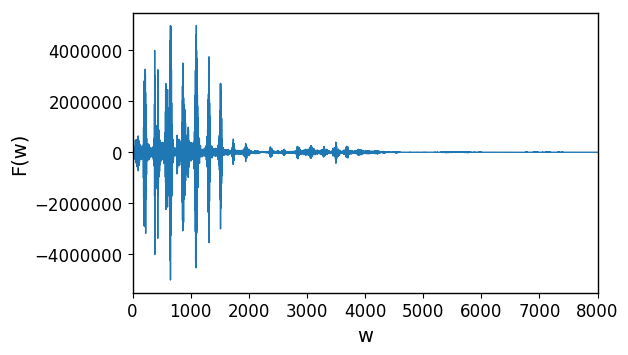

In [12]:
plt.plot(np.arange(data.size), fft.fft(data).real)
plt.xlim(0, 8000)
plt.xlabel('w')
plt.ylabel('F(w)')

In [13]:
samples_per_chunk = 160
chunks = data.size / samples_per_chunk
chunks

100

In [14]:
acc = []
for chunk in range(chunks):
     output = fft.fft(data[chunk * samples_per_chunk:(chunk + 1) * samples_per_chunk]).real
     acc.append(np.where(output[0:8000] >= 0.0, output[0:8000], 0.0))

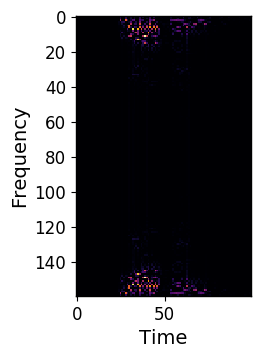

In [15]:
plt.imshow(np.array(acc).T, cmap='inferno', interpolation='none')
plt.xlabel('Time')
plt.ylabel('Frequency')

### Below we use SciPy to compute the spectrogram:

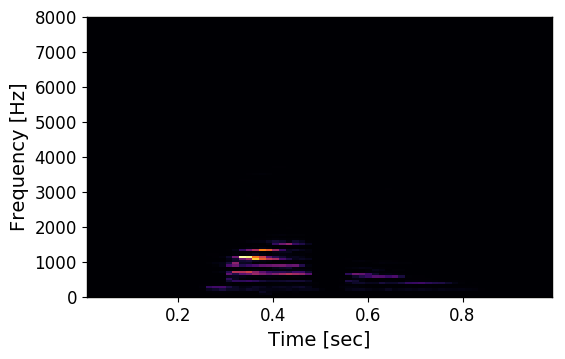

In [16]:
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read(f)
assert sample_rate == 16000
assert samples.size == 16000
frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, window=('tukey', 0.25))

plt.pcolormesh(times, frequencies, spectrogram, cmap='inferno')
plt.ylim(0, 8e3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

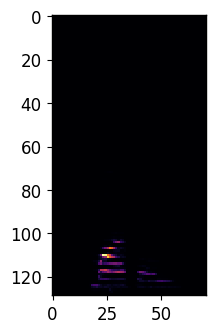

In [17]:
plt.imshow(spectrogram[::-1,], cmap='inferno', interpolation='none')

In [18]:
height, width = spectrogram.shape
height, width

(129, 71)

In [19]:
spectrogram.min(), spectrogram.mean(), spectrogram.max()

(6.7560459e-09, 2645.7983, 654511.19)

### Prepare the data for Tensorflow

In [20]:
import glob

In [21]:
yes = glob.glob('datasets/speech_commands_v0.01/yes/*.wav')
nine = glob.glob('datasets/speech_commands_v0.01/nine/*.wav')

Shuffle the paths and labels:

In [22]:
paths = np.array(yes + nine)
labels = np.append(np.zeros(len(yes), dtype=np.int32), [np.ones(len(nine), dtype=np.int32)])
indices = np.arange(paths.size)
np.random.shuffle(indices)

In [23]:
paths = paths[indices]
labels = labels[indices]

In [24]:
np.bincount(labels)

array([2377, 2364])

In [25]:
clean_paths = []
clean_labels = []
for path, label in zip(paths, labels):
     sample_rate, samples = wavfile.read(path)
     if (sample_rate == 16000) and (samples.size == 16000):
          clean_paths.append(path)
          clean_labels.append(label)
paths = np.array(clean_paths)
labels = np.array(clean_labels)

In [26]:
np.bincount(labels)

array([2157, 2174])

Create a train-test split:

In [27]:
train_size = 0.8
thres = int(paths.size * train_size)
train_paths = paths[:thres]
train_labels = labels[:thres]
test_paths = paths[thres:]
test_labels = labels[thres:]

In [28]:
def fetch_batch(sound_paths, sound_labels, batch_size):
     indices = np.random.choice(np.arange(sound_paths.size), size=batch_size, replace=False)
     acc = []
     for path in sound_paths[indices]:
          sample_rate, samples = wavfile.read(path)
          assert sample_rate == 16000, 'Sample rate mismatch'
          assert samples.size == 16000, 'Samples mismatch'
          frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate)
          acc.append(spectrogram / spectrogram.max()) # scale to 0, 1
     return np.array(acc), sound_labels[indices]

In [29]:
X_test, y_test = fetch_batch(test_paths, test_labels, test_paths.size)

### Train a CNN in tensorflow

In [30]:
import tensorflow as tf

In [31]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, height, width), name="X")
     X_reshaped = tf.reshape(X, shape=[-1, height, width, 1])
     y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")

In [ ]:
conv_1 = tf.layers.conv2d(X_reshaped, filters=20, kernel_size=3, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
max_pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
conv_2 = tf.layers.conv2d(max_pool_1, filters=10, kernel_size=2, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
max_pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

with tf.name_scope("fc1"):
     full_1 = tf.layers.dense(tf.reshape(max_pool_2, shape=[-1, 32]), units=50, activation=tf.nn.relu)

with tf.name_scope("output"):
     logits = tf.layers.dense(full_1, units=2, activation=None, name='outputs')
     Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [33]:
with tf.name_scope('loss'):
     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
     loss = tf.reduce_mean(xentropy, name='loss')

In [34]:
learning_rate = 0.001
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [35]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
cm = tf.confusion_matrix(y, tf.arg_max(logits, dimension=1))

In [36]:
init = tf.global_variables_initializer()

In [37]:
batch_size = 200
n_epochs = 100

In [ ]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(n_epochs):
          for iteration in range(train_paths.size // batch_size):
               X_batch, y_batch = fetch_batch(train_paths, train_labels, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if (epoch % 10 == 0):
               print epoch, "train:", accuracy.eval(feed_dict={X:X_batch, y:y_batch})
     #print "train (entire):", accuracy.eval(feed_dict={X:train_paths, y:train_labels})
     #print "test:", accuracy.eval(feed_dict={X:X_test, y:y_test})
     #print "CM:\n", cm.eval(feed_dict={X:X_test, y:y_test})